# Analysis of S&P 500 between 2013-2018
### Fall 2025 Data Scieence Project
### Contributions: Aidan Mendes, Alexandru Cara, Anthony Nguyen, Bryan Dang, Manomay Bhavani

* A: Project idea:
  * Bryan - Suggested the hypothesis we can test that would include our progress from checkpoint 1 and 2.
* B: Dataset Curation and Preprocessing
  * Bryan - Set up data cleaning/curation pipeline and explanations.
* C: Data Exploration and Summary Statistics
  * Aidan - Created bar graphs showing the top most volatile stocks
  * Alexandru - Scatter-plot to show profitability of simple trading algorithm.
  * Anthony - Correlation heatmap of top 30 stocks
  * Manomay - Top 20 Tickers by % growth
* D: ML Algorithm Design/Development
  * Bryan - Collaborated to choose an ML algorithm and to test the hypothesis
  * Alexandru - Helped choose an the process for ML algorithms.
  * Manomay - Helped work on ML KNN algorithm
* E: ML Algorithm Training and Test Data Analysis
  * Alexandru - Developed general template for ML algorithms, made for RandomForest and helped clean data.
  * Manomay - Developed KNN algorithm, and helped demonstrate including extra parsed information via log_ret can improve an algorithm.
* F: Visualization, Result Analysis, Conclusion
  * Aidan - Wrote Insights and Conclusions
  * Anthony - Plotted comparison of trading cumulative returns between models
  * Bryan - Collaborated to draw insights from the results and possible conclusions
* G: Final Tutorial Report Creation


## Introduction
The stock market represents one of the most dynamic systems in the modern economy, where investors and analysts continuously seek to answer a fundamental question: **Can historical market data reliably predict future stock performance?**

This project investigates the predictive power of historical stock market patterns by training a machine learning model on S&P 500 company data from 2013-2018 and validating their performance against actual market outcomes from 2018-2023. Using two comprehensive datasets historical stock prices for S&P 500 companies (2013-2018) and Yahoo Finance daily data for multiple equities, ETFs, and indexes (2018-2023) we aim to determine whether patterns identified in one market period can effectively forecast trends in subsequent years.

The importance of this analysis extends beyond academic interest. If historical patterns prove predictive, it validates systematic, data driven investment approaches. Conversely, if models fail to generalize across time periods, it reinforces market efficiency theory and highlights the limitations of backward looking analysis.

## Data Curation

Data Sources
While the NASDAQ exchange lists over 3,000 stocks, market momentum is largely driven by the largest, most influential companies. For this reason, we focus our analysis on the S&P 500 index, which comprises the top 500 publicly traded companies in the United States and serves as a reliable barometer for overall market performance.
Our analysis utilizes two complementary datasets sourced from Kaggle:

S&P 500 Historical Stock Prices (2013-2018)
* [1]: This dataset contains daily historical stock prices for all companies listed on the S&P 500 index during the five-year period from 2013 to 2018. The data includes key metrics such as opening price, closing price, daily high and low values, trading volume, and adjusted closing prices.
Yahoo Finance Dataset (2018-2023)
* [2]: This dataset provides daily stock market data for multiple assets including equities, ETFs, and indexes from April 1, 2018 to March 31, 2023. It contains 1,257 rows and 7 columns, offering a comprehensive view of market performance during this period. The data was sourced directly from Yahoo Finance, a widely trusted platform for financial data.

Together, these datasets provide ten years of continuous market data, enabling us to train predictive models on one period and rigorously test their performance on subsequent, unseen market conditions.
References
* [1] Nugent, C. (2017). S&P 500 Stock Data. Kaggle. https://www.kaggle.com/datasets/camnugent/sandp500
* [2] Arora, S. (2023). Yahoo Finance Dataset (2018-2023). Kaggle. https://www.kaggle.com/datasets/suruchiarora/yahoo-finance-dataset-2018-2023


Installation library to access kaggle resources in Python

In [ ]:
!pip install kagglehub[pandas-datasets] --quiet

The first step is to import libraries needed for this tutorial

In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from kagglehub import KaggleDatasetAdapter

**Importing the data:** Kaggle is a website that houses thousands of datasets, available to download for free. We utilized the kagglehub library to load the datasets. This code block will retrieve the kaggle datasets and load them into dataframes.

Resource to find your own dataset - https://www.kaggle.com/datasets

In [ ]:
file_path = "yahoo_data.xlsx"
file_path2 = "all_stocks_5yr.csv"

df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "suruchiarora/yahoo-finance-dataset-2018-2023",
  file_path,
)

df2 = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "camnugent/sandp500",
  file_path2,
)

print("First 5 records:\n", df.head())
print("First 5 records:\n", df2.head())

Using Colab cache for faster access to the 'yahoo-finance-dataset-2018-2023' dataset.
Using Colab cache for faster access to the 'sandp500' dataset.
First 5 records:
            Date      Open      High       Low    Close*  Adj Close**  \
0  Apr 28, 2023  33797.43  34104.56  33728.40  34098.16     34098.16   
1  Apr 27, 2023  33381.66  33859.75  33374.65  33826.16     33826.16   
2  Apr 26, 2023  33596.34  33645.83  33235.85  33301.87     33301.87   
3  Apr 25, 2023  33828.34  33875.49  33525.39  33530.83     33530.83   
4  Apr 24, 2023  33805.04  33891.15  33726.09  33875.40     33875.40   

      Volume  
0  354310000  
1  343240000  
2  321170000  
3  297880000  
4  252020000  
First 5 records:
          date   open   high    low  close    volume Name
0  2013-02-08  15.07  15.12  14.63  14.75   8407500  AAL
1  2013-02-11  14.89  15.01  14.26  14.46   8882000  AAL
2  2013-02-12  14.45  14.51  14.10  14.27   8126000  AAL
3  2013-02-13  14.30  14.94  14.25  14.66  10259500  AAL
4  2013

---

#### Transform Data





**Column Standardization:**
Though both datasets are similar there can be many nuances specifically with naming that can make modeling frustrating. So let's standardize the columns/features of both datasets.

In [ ]:
# Helper
def pick(df, *candidates):
    """Case-insensitive column name matcher."""
    lookup = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand.lower() in lookup:
            return lookup[cand.lower()]
    return None

def standardize_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Identify columns using flexible matching
    date_col  = pick(df, "Date")
    open_col  = pick(df, "Open")
    high_col  = pick(df, "High")
    low_col   = pick(df, "Low")
    close_col = pick(df, "Close")
    adj_col   = pick(df, "Adj Close", "AdjClose")
    vol_col   = pick(df, "Volume")
    name_col  = pick(df, "Ticker", "Symbol", "Name", "Stock")

    if not date_col:
        raise ValueError(f"No date column found among {list(df.columns)}")

    # Build rename mapping
    rename_map = {
        date_col: "Date",
        open_col: "Open",
        high_col: "High",
        low_col: "Low",
        close_col: "Close",
    }
    if adj_col: rename_map[adj_col] = "Adj Close"
    if vol_col: rename_map[vol_col] = "Volume"
    if name_col: rename_map[name_col] = "Name"

    # Apply renaming
    df = df.rename(columns={k: v for k, v in rename_map.items() if k})

    return df

**Data Cleaning pt.1:** When importing datasets, they are often wrapped in difficult types to utilize. For example, numbers being represented as strings. This block of code will convert Data Types so they are intuitive to use (ex. numeric strings to ints)

In [ ]:
def convert_data_types(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Convert date column to datetime
    if "Date" in df:
        df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

    # Convert numeric columns
    for col in df.columns:
        if col not in ["Date", "Name"]:
            df[col] = pd.to_numeric(df[col], errors="coerce")
            # Cast to integer if all values are whole numbers
            if pd.api.types.is_numeric_dtype(df[col]) and (df[col].dropna() % 1 == 0).all():
                df[col] = df[col].astype("Int64")

    # Ensure Name column is string type
    if "Name" in df:
        df["Name"] = df["Name"].astype(str).str.strip()

    return df

**Data Cleaning pt.2**: Often times datasets will have missing or faulty entries, it is important to clean these datasets. This code block ensure data quality so noise isn't "accidentally" introduced to the analysis later

In [ ]:
def fix_data_quality(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Fix inverted High/Low values
    if "High" in df and "Low" in df:
        swap = df["Low"] > df["High"]
        if swap.any():
            df.loc[swap, ["Low", "High"]] = df.loc[swap, ["High", "Low"]].to_numpy()

    # Drop rows with invalid dates
    if "Date" in df:
        df = df.dropna(subset=["Date"])

    # Sort by Name (if exists) and Date
    sort_cols = ["Name", "Date"] if "Name" in df else ["Date"]
    df = df.sort_values(sort_cols).reset_index(drop=True)

    return df

**Feature Engineering** - Added profit feature indicating whether the day was a profit or a loss. Return feature calculating % gain or loss on the day. Log Return feature normally distributed returns for modeling.

If you are struggling with Pandas try out some of these tutorials: https://pandas.pydata.org/docs/getting_started/intro_tutorials/



In [ ]:
def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Add Profit feature: 1 if profitable day, 0 otherwise
    if "Close" in df and "Open" in df:
        df["Profit"] = (df["Close"] > df["Open"]).astype(int)

    # Add return features
    if "Close" in df:
        has_names = "Name" in df

        if has_names:
            # Calculate returns separately for each stock
            df["ret"] = df.groupby("Name")["Close"].pct_change()
            df["log_ret"] = np.log(df["Close"]).groupby(df["Name"]).diff()
        else:
            # Calculate returns for single stock
            df["ret"] = df["Close"].pct_change()
            df["log_ret"] = np.log(df["Close"]).diff()

    return df


**Cleaning Pipeline** - Implements a function that runs all of the data cleaning methods.

In [ ]:
def clean_stock_data_simple(df: pd.DataFrame) -> pd.DataFrame:

    # Standardize column names
    df = standardize_columns(df)

    # Convert to appropriate data types
    df = convert_data_types(df)

    # Fix data quality issues
    df = fix_data_quality(df)

    # Engineer features
    df = engineer_features(df)

    # Select necessary & checked features
    keep = ["Date"] + (["Name"] if "Name" in df else []) + \
           [c for c in ["Open", "High", "Low", "Close", "Adj Close", "Volume",
                       "Profit", "ret", "log_ret"] if c in df]

    return df[keep]

**Cleaning Driver** - Runs the cleaning function on both of the datasets to complete the cleaning.

In [ ]:
df_clean  = clean_stock_data_simple(df)
df2_clean = clean_stock_data_simple(df2)

print("First datset\n", df_clean.head())
print("Second dataset\n", df2_clean.head())

First datset
         Date      Open      High       Low     Volume
0 2018-05-01  24117.29  24117.29  23808.19  380070000
1 2018-05-02  24097.63  24185.52  23886.30  385350000
2 2018-05-03  23836.23  23996.15  23531.31  389240000
3 2018-05-04  23865.22  24333.35  23778.87  329480000
4 2018-05-07  24317.66  24479.45  24263.42  307670000
Second dataset
         Date Name   Open   High    Low  Close   Volume  Profit       ret  \
0 2013-02-08    A  45.07  45.35  45.00  45.08  1824755       1       NaN   
1 2013-02-11    A  45.17  45.18  44.45  44.60  2915405       0 -0.010648   
2 2013-02-12    A  44.81  44.95  44.50  44.62  2373731       0  0.000448   
3 2013-02-13    A  44.81  45.24  44.68  44.75  2052338       0  0.002913   
4 2013-02-14    A  44.72  44.78  44.36  44.58  3826245       0 -0.003799   

    log_ret  
0       NaN  
1 -0.010705  
2  0.000448  
3  0.002909  
4 -0.003806  


-----

### Exploratory Data Analysis (Checkpoint 2)

This code is all about seeing how the top 30 most-traded stocks move together.
1. First, it makes sure the dates are correct and figures out which stocks are the top 30 by average trading volume.
2. Calculates the daily returns (the percentage change in closing price) for each of those 30 stocks. It takes those returns and pivots the data to compare every stock's returns on the same day
3. Calculates the Correlation Matrix to get a number showing how closely each pair of stocks moves
4. Takes that matrix and turns it into a heatmap to easily see the relations.

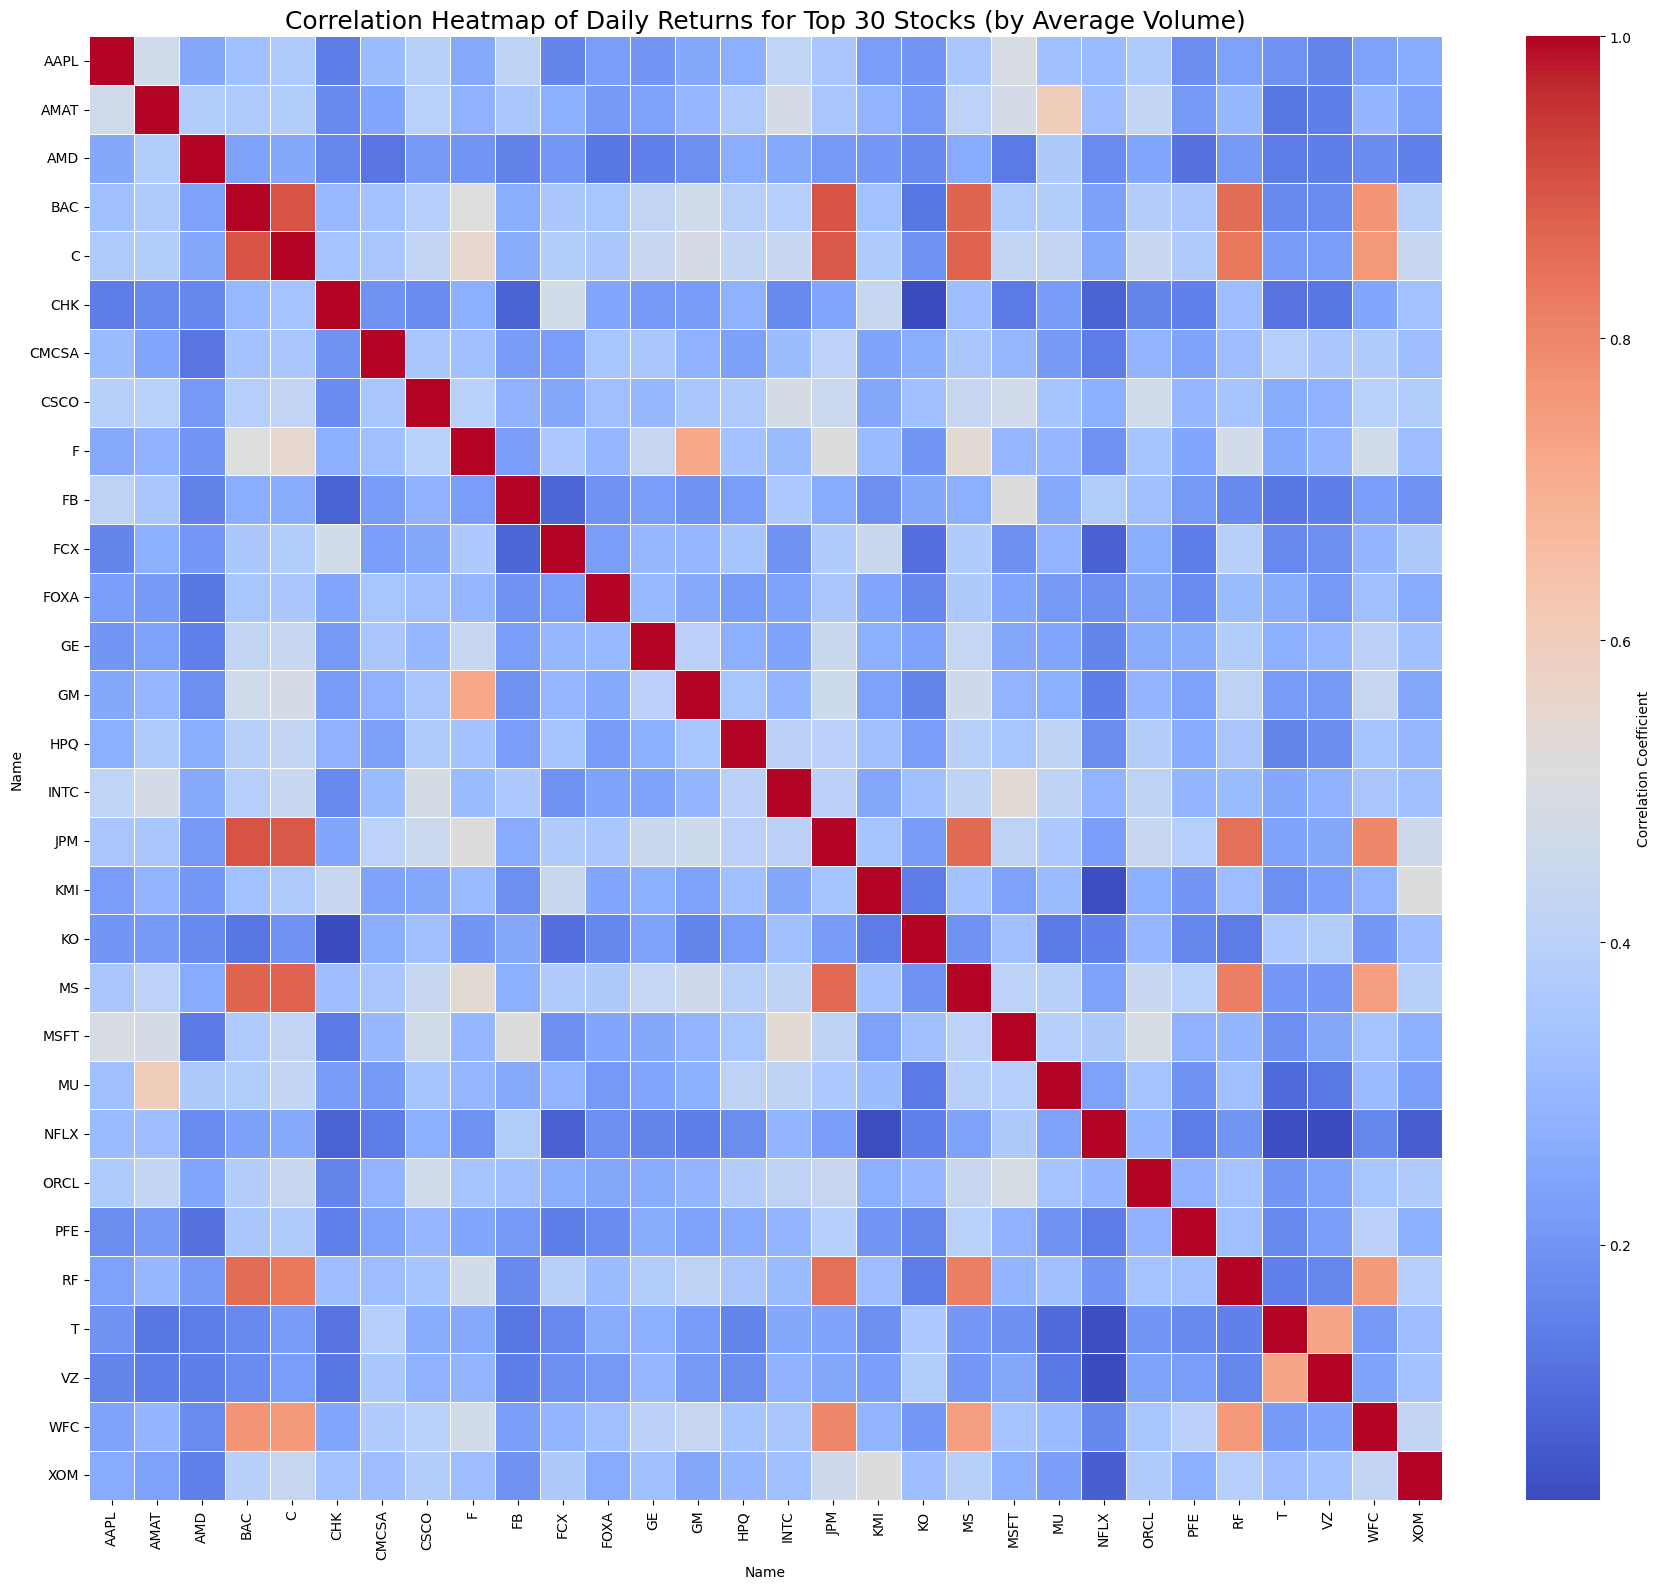

In [ ]:
# Ensure 'date' is datetime
df2_clean['Date'] = pd.to_datetime(df2_clean['Date'])

# Calculate the average volume for each stock
avg_volume = df2_clean.groupby('Name')['Volume'].mean().sort_values(ascending=False)
top_30_names = avg_volume.head(30).index.tolist()

# Filter the DataFrame to include only the top 30 stocks
df_top30 = df2_clean[df2_clean['Name'].isin(top_30_names)].copy()

# Calculate daily percentage change (returns) for the 'close' price for each stock
df_top30.loc[:, 'Returns'] = df_top30.groupby('Name')['Close'].pct_change()

# Pivot the data: Date is index, Stock Name is columns, Values are Returns
returns_pivot = df_top30.pivot(index='Date', columns='Name', values='Returns').dropna()

# Calculate the Correlation Matrix
correlation_matrix = returns_pivot.corr()


plt.figure(figsize=(18, 16))
sns.heatmap(
    correlation_matrix,
    annot=False,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=.5,
    cbar_kws={'label': 'Correlation Coefficient'}
)

plt.title('Correlation Heatmap of Daily Returns for Top 30 Stocks (by Average Volume)', fontsize=18)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()

# Save the plot
heatmap_file_name = "top_30_stocks_correlation_heatmap.png"
plt.savefig(heatmap_file_name)

This portion of code analyzes the data by taking the average difference of the High/Low position of each company.
1. Finds the difference between high and low for each entry of the table
2. Groups by company and take the average.

This data is meant to show the average volatility of each company over the time frame. Below are the top 30 most volatile companies.

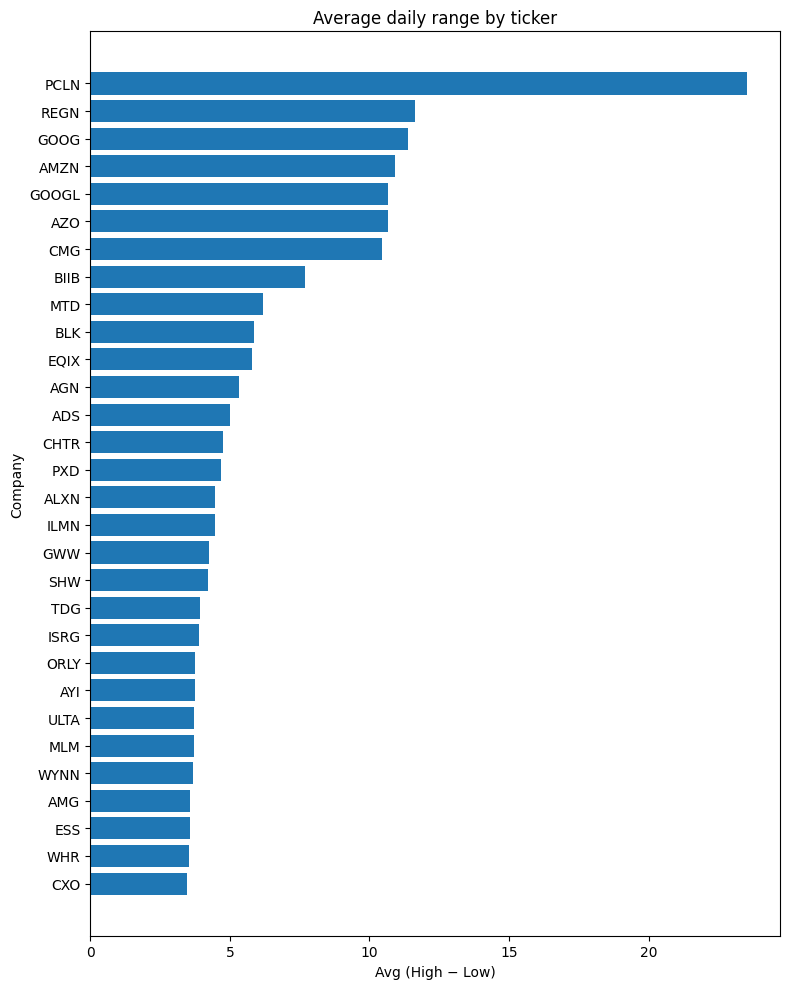

In [ ]:
df_new  = df2_clean.copy()
df_new['Diff'] = df_new['High'] - df_new['Low']
df_avgs = df_new.groupby('Name')['Diff'].mean().rename('avg_high_low')

to_plot = df_avgs.sort_values(ascending=False).head(30)

plt.figure(figsize=(8,10))
plt.barh(to_plot.index, to_plot.values)
plt.gca().invert_yaxis()
plt.xlabel('Avg (High − Low)')
plt.ylabel('Company')

plt.title('Average daily range by ticker')
plt.tight_layout()
plt.show()

This portion mocks a simple investment strategy: Buy next day's open if previous day had a close 10% higher than open price. Then use a scatterplot to display the profits or losses.

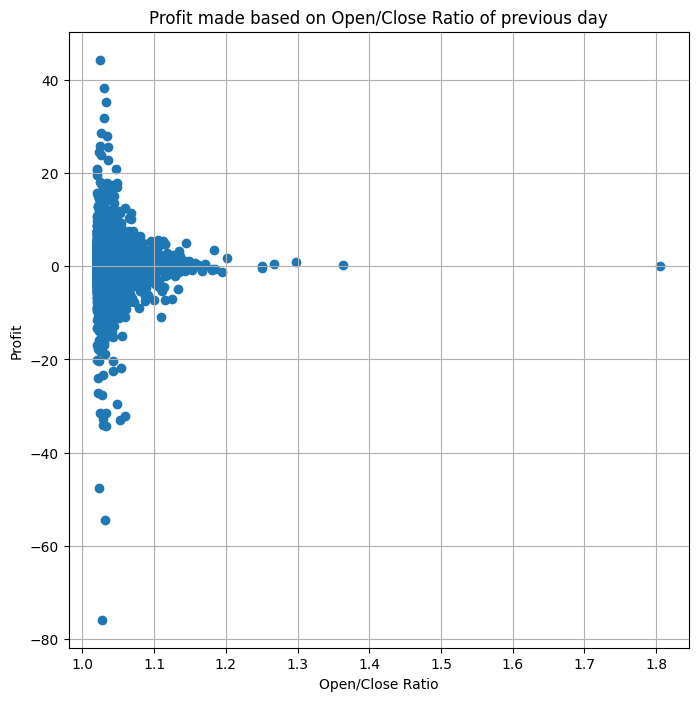

In [ ]:
# previous_days_open = df_clean['Open'].shift(1)
# previous_days_close = df_clean['Close'].shift(1)
# for i in range previous_days_

# Investing strategy, buy next day's open if previous day had a close 2% higher than open price.
my_df = df2_clean.copy()
my_df['PrevDayOpen'] = my_df['Open'].shift(1)
my_df['PrevDayClose'] = my_df['Close'].shift(1)

buy_today_condition = my_df['PrevDayClose'] > 1.02 * my_df['PrevDayOpen']

my_df['TodaysTradeResult'] = None
my_df

my_df.loc[buy_today_condition, 'TodaysTradeResult'] = my_df['Close'] - my_df['Open']
my_df = my_df[['PrevDayClose', 'PrevDayOpen', 'TodaysTradeResult']].dropna()

plt.figure(figsize=(8,8))
plt.scatter(my_df['PrevDayClose']/my_df['PrevDayOpen'], my_df['TodaysTradeResult'])
plt.title("Profit made based on Open/Close Ratio of previous day")
plt.ylabel("Profit")
plt.xlabel("Open/Close Ratio")
plt.grid(True)
plt.show()

This section of the code finds the top 20 stocks that have grown the most

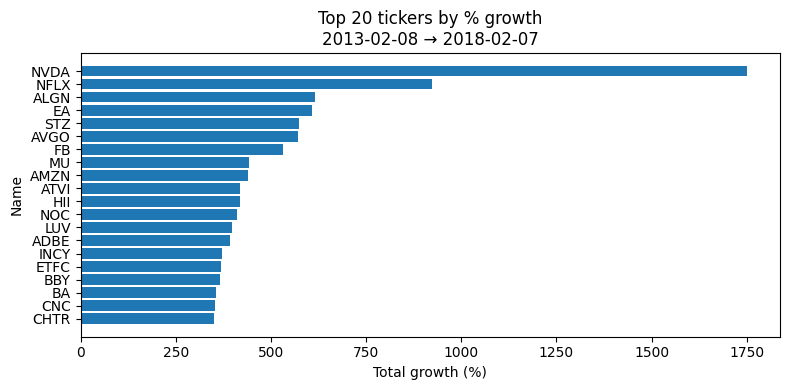

In [ ]:
prices = df2_clean.copy()

# Make sure all dates are in the same format
prices["Date"] = pd.to_datetime(prices["Date"], errors="coerce")
prices = prices.dropna(subset=["Name", "Date", "Close"]).sort_values(["Name", "Date"])

# Finds the First and Last date to compare stock prices
start_date = prices["Date"].min()
end_date = prices["Date"].max()

timeframe = prices[(prices["Date"] >= start_date) & (prices["Date"] <= end_date)].copy()

# First & last close per Name in the timeframe
first_name = (timeframe.groupby("Name")[["Date", "Close"]].first().rename(columns={"Date": "FirstDate", "Close": "FirstClose"}))
last_name = (timeframe.groupby("Name")[["Date", "Close"]].last().rename(columns={"Date": "LastDate", "Close": "LastClose"}))

# Join first/last and compute growth
growth_graph = first_name.join(last_name, how="inner")
growth_graph = growth_graph[growth_graph["FirstClose"] > 0].copy()
trading_span = (growth_graph["LastDate"] - growth_graph["FirstDate"]).dt.days.clip(lower=1)
growth_graph["TotalGrowth"] = growth_graph["LastClose"] / growth_graph["FirstClose"] - 1.0
growth_graph["CAGR"] = (growth_graph["LastClose"] / growth_graph["FirstClose"]) ** (365 / trading_span) - 1.0

# Rank and display the top N gainers
top_n = 20
top_growth = growth_graph.sort_values("TotalGrowth", ascending=False).head(top_n)

# Create the Graph
plt.figure(figsize=(8, 4))
plt.barh(top_growth.index[::-1], (100 * top_growth["TotalGrowth"][::-1]))
plt.xlabel("Total growth (%)")
plt.ylabel("Name")
plt.title(f"Top {top_n} tickers by % growth\n"f"{start_date.date()} → {end_date.date()}")
plt.tight_layout()
plt.show()

The conclusion is that in the top 20, NVDA has growth the most over the 5 years of 2013 to 2018.

---

### Primary Analysis

Connecting Exploration to Prediction
Our exploratory analysis of 2013-2018 data revealed patterns that inform our predictive approach: stocks within sectors move together, companies show consistent volatility ranges, momentum strategies have mixed success, and growth trajectories vary by stock. These insights raise our central question: Can we predict whether a stock will be profitable on a given day using patterns from 2013-2018, and do these patterns hold in 2018-2023?

We frame this as a binary classification problem (predicting if Close > Open) rather than regression for three reasons:

* An investor's perspective to buy or sell, not the actual stock price
* Aa simple classifier, machine learning can learn more complex decision boundaries
* An evaluation comparing accuracy between 2013-2018 and 2018-2023 directly

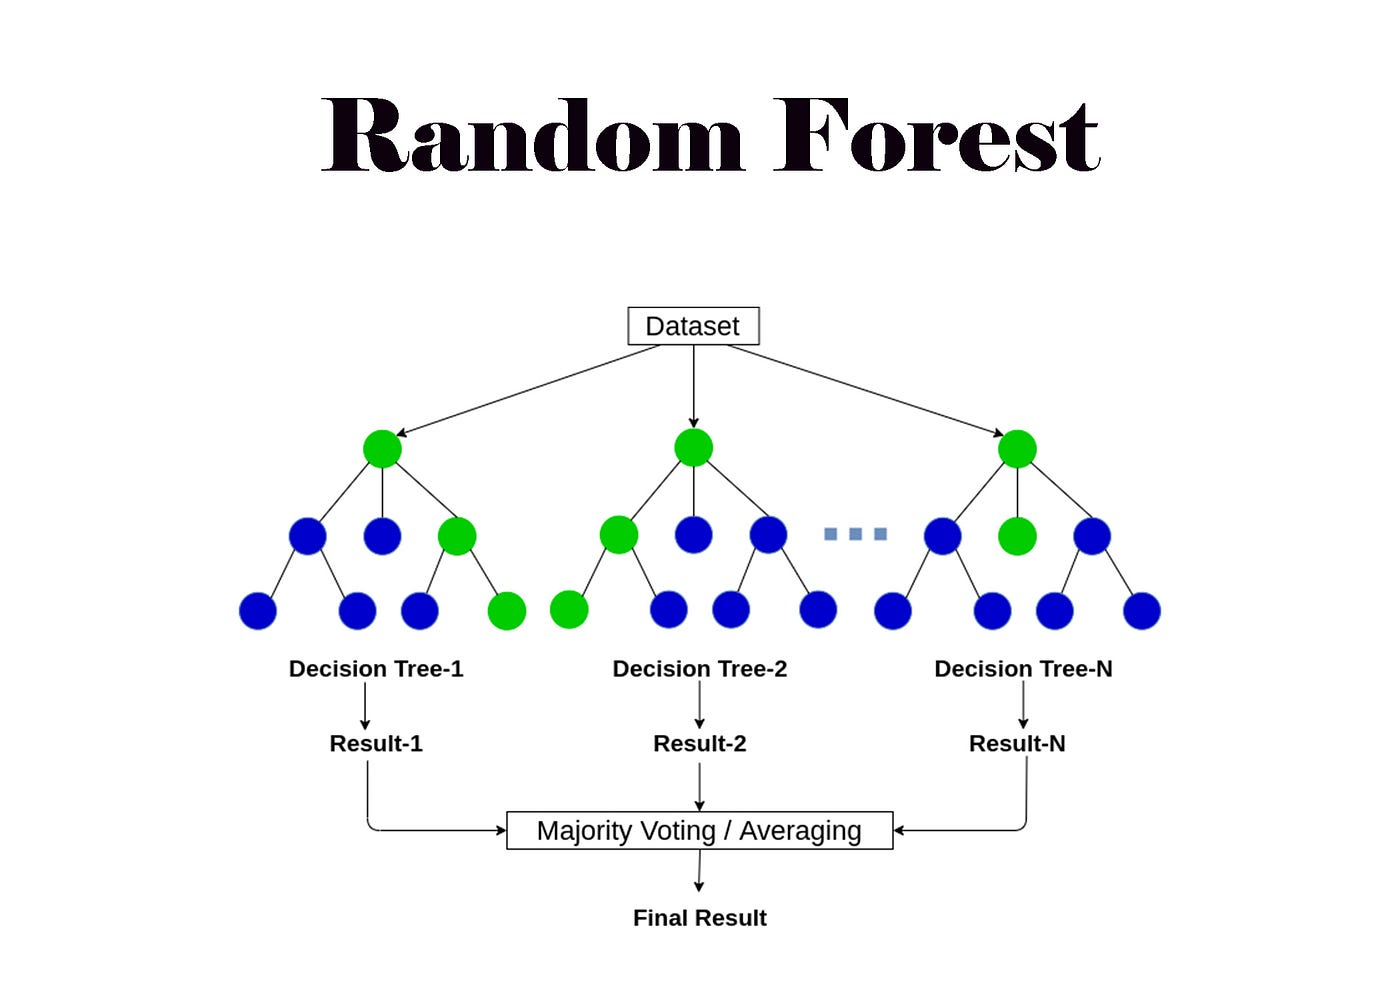

Here, it can be seen a more indepth version of ML training, with the end goal of predicting profitable and non-profitable days in a more generic sense.
Using Random Forest in all honesty may not seems as intuitive, but when facing with this vacuum of pricing data it is not a terrible choice, as it strikes a good balance between speed and robustness to outliers.
If you have more information, diverse information, it may be good to analyze pieces seperately, (as seen later via log_ret) and use a CNN model.

Here is a more generic way to train an ML model such that other versions (such as knn) can easily be updated and compared.

The process is pretty simple, important from sklearn a train_test_split so that the AI model can have a way too compare the model it trained to some data it has not seen before. The k-folds allows for an iterative version of the process, training on a large subsection of the training data and using part of the training data as a test.
The final comparsion is done to see truly how well the model runs.

There is some important data cleaning that needed to be done here.
Previous day data is important, it allows for a decision to be made on old information, it would invalidate the point of the ML model if we provide it current Open/Close price, as a simple calculation Open < Close would provide if it was a profitable day or not. Using previous day gets to the core idea to make a successful prediction.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
import numpy as np # Import numpy for log function

ml_df = df2_clean.copy()

# Add LogRet features
for i in range(1, 6):   # creates LogRet_1 ... LogRet_5
    ml_df[f'LogRet_{i}'] = np.log(ml_df['Close'] / ml_df['Close'].shift(i))

# Add info s.t. you can make an appropriate guess.
ml_df['PrevDayOpen'] = ml_df['Open'].shift(1)
ml_df['PrevDayClose'] = ml_df['Close'].shift(1)
ml_df['PrevDayHigh'] = ml_df['High'].shift(1)
ml_df['PrevDayLow'] = ml_df['Low'].shift(1)
ml_df['PrevDayVolume'] = ml_df['Volume'].shift(1)

# Shift LogRet features by one day to use previous day's information
for i in range(1, 6):
    ml_df[f'LogRet_{i}'] = ml_df[f'LogRet_{i}'].shift(1)

ml_df = ml_df.dropna()

# Here is getting the information that will be used to make a prediction
X = ml_df[['PrevDayClose', 'PrevDayOpen', 'PrevDayVolume', 'PrevDayHigh', 'PrevDayLow',
           'LogRet_1', 'LogRet_2', 'LogRet_3', 'LogRet_4', 'LogRet_5']]
# Correct prediction result
Y = ml_df['Profit'].astype(bool)
# Split it
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.8)
# Scale so in general, you can plug and play other models.
my_scaler = StandardScaler()
my_scaler.fit(X_train)
X_train_scaled = my_scaler.transform(X_train)
X_test_scaled = my_scaler.transform(X_test)

# Store the fitted scaler globally
global_rf_scaler = my_scaler

# K-fold allows for iterative training/testing.
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=10)
# Actually run the model.
forest_model = RandomForestClassifier(random_state=10)
# Check how accurate the model is.
cv_scores = cross_val_score(forest_model, X_train_scaled, y_train, cv=skf, scoring='accuracy')
print(f"Cross-validated Accuracy: {cv_scores.mean()} (+/- {cv_scores.std()})")

# Fit the model to the training data and store it globally
forest_model.fit(X_train_scaled, y_train)
global_forest_model = forest_model

Cross-validated Accuracy: 0.5092561393596267 (+/- 0.0022674205934000817)


Results of 50% is pretty close to a guess. And to be frank this is to be expected! The problem space of stock trading is pretty thoroughly explored, more simplistic models will struggle to make inferences on a winning or selling day based solely on past information. Often times other real-time resources are pulled in like news articles. Other tactics like rapid trades don't rely on ML at all. All of these factors come together too make most ML models (55+%) unsuccessful in trading.

***KNN Algorithm***

In addition to the Random Forest Model, we also chose to use the KNN algorithm to compare the results of different classification methods. The change is not major as we train models on the same features. Since the code is already robust, all that need to be changed was RandomForestClassifier to KNeighborsClassifier.

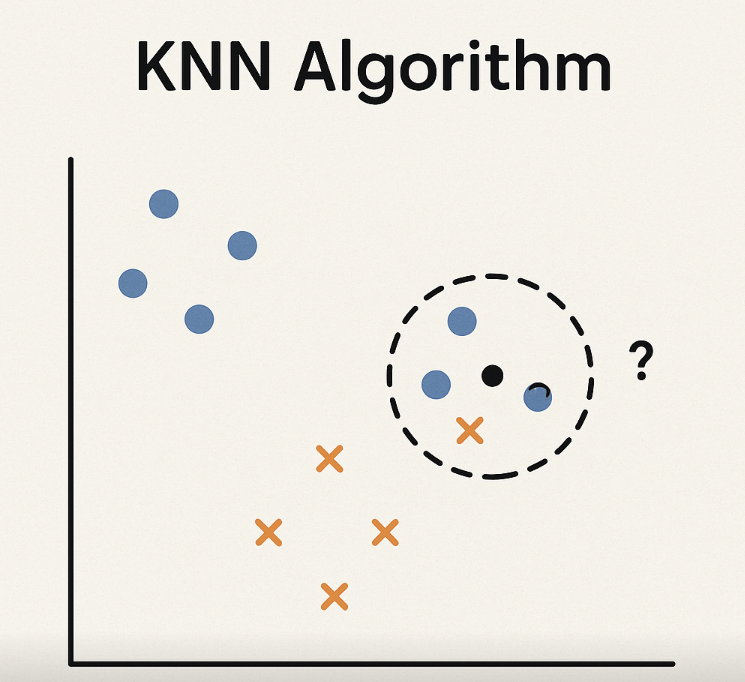

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

ml_df = df2_clean.copy()

for i in range(1, 6):   # creates LogRet_1 ... LogRet_5
    ml_df[f'LogRet_{i}'] = np.log(ml_df['Close'] / ml_df['Close'].shift(i))

ml_df['PrevDayOpen'] = ml_df['Open'].shift(1)
ml_df['PrevDayClose'] = ml_df['Close'].shift(1)
ml_df['PrevDayHigh'] = ml_df['High'].shift(1)
ml_df['PrevDayLow'] = ml_df['Low'].shift(1)
ml_df['PrevDayVolume'] = ml_df['Volume'].shift(1)

ml_df['LogRet_1'] = ml_df['LogRet_1'].shift(1)
ml_df['LogRet_2'] = ml_df['LogRet_2'].shift(1)
ml_df['LogRet_3'] = ml_df['LogRet_3'].shift(1)
ml_df['LogRet_4'] = ml_df['LogRet_4'].shift(1)
ml_df['LogRet_5'] = ml_df['LogRet_5'].shift(1)

ml_df = ml_df.dropna()

X = ml_df[['PrevDayClose', 'PrevDayOpen', 'PrevDayVolume', 'PrevDayHigh', 'PrevDayLow',
           'LogRet_1', 'LogRet_2', 'LogRet_3', 'LogRet_4', 'LogRet_5']]
Y = ml_df['Profit'].astype(bool)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.8)

my_scaler = StandardScaler()
my_scaler.fit(X_train)
X_train_scaled = my_scaler.transform(X_train)
X_test_scaled = my_scaler.transform(X_test)

# Store the fitted scaler globally
global_knn_scaler = my_scaler

k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=10)

knn_model = KNeighborsClassifier()

print("Got here")
cv_scores = cross_val_score(knn_model, X_train_scaled, y_train, cv=skf, scoring='accuracy')
knn_model_accuracy = cv_scores.mean()
knn_std_dev = cv_scores.std()
print(f"Cross-validated Accuracy: {knn_model_accuracy} (+/- {knn_std_dev})")

# Fit the model to the training data and store it globally
knn_model.fit(X_train_scaled, y_train)
global_knn_model = knn_model

Got here
Cross-validated Accuracy: 0.5034114179569704 (+/- 0.0015731227410710803)


### Visualization

This code block utilizes the previously trained Random Forest and KNN models to generate profit predictions for stock 'A' using engineered features from historical data. It then simulates a trading strategy based on these predictions, alongside a 'Buy and Hold' strategy for comparison. The cumulative returns of all three strategies are then calculated and visualized in a plot, allowing for a clear assessment of how well each strategy performs over time.

In [ ]:
# Prepare df_predict from df2_clean
df_predict = df2_clean.copy()

# Add LogRet features
for i in range(1, 6):   # creates LogRet_1 ... LogRet_5
    df_predict[f'LogRet_{i}'] = np.log(df_predict['Close'] / df_predict['Close'].shift(i))

# Add previous day's information.
df_predict['PrevDayOpen'] = df_predict['Open'].shift(1)
df_predict['PrevDayClose'] = df_predict['Close'].shift(1)
df_predict['PrevDayHigh'] = df_predict['High'].shift(1)
df_predict['PrevDayLow'] = df_predict['Low'].shift(1)
df_predict['PrevDayVolume'] = df_predict['Volume'].shift(1)

# Shift LogRet features by one day to use previous day's information
for i in range(1, 6):
    df_predict[f'LogRet_{i}'] = df_predict[f'LogRet_{i}'].shift(1)

# Drop rows with NaN values resulting from feature engineering
df_predict = df_predict.dropna()

print("Prepared df_predict with engineered features and dropped NaNs.")
df_predict.head()

Prepared df_predict with engineered features and dropped NaNs.


,Date,Name,Open,High,Low,Close,Volume,Profit,ret,log_ret,LogRet_1,LogRet_2,LogRet_3,LogRet_4,LogRet_5,PrevDayOpen,PrevDayClose,PrevDayHigh,PrevDayLow,PrevDayVolume
6,2013-02-19,A,42.21,43.12,42.210,43.01,4116141,1,0.017988,0.017828,-0.053681,-0.057487,-0.054578,-0.054130,-0.064834,43.48,42.25,44.24,42.210,14657315
7,2013-02-20,A,42.84,42.85,42.225,42.24,3873183,0,-0.017903,-0.018065,0.017828,-0.035853,-0.039659,-0.036750,-0.036301,42.21,43.01,43.12,42.210,4116141
8,2013-02-21,A,42.14,42.14,41.470,41.63,3415149,0,-0.014441,-0.014547,-0.018065,-0.000237,-0.053918,-0.057724,-0.054815,42.84,42.24,42.85,42.225,3873183
9,2013-02-22,A,41.83,42.07,41.580,41.80,3354862,0,0.004084,0.004075,-0.014547,-0.032612,-0.014783,-0.068464,-0.072270,42.14,41.63,42.14,41.470,3415149
10,2013-02-25,A,42.09,42.22,41.290,41.29,3622460,0,-0.012201,-0.012276,0.004075,-0.010471,-0.028536,-0.010708,-0.064389,41.83,41.80,42.07,41.580,3354862


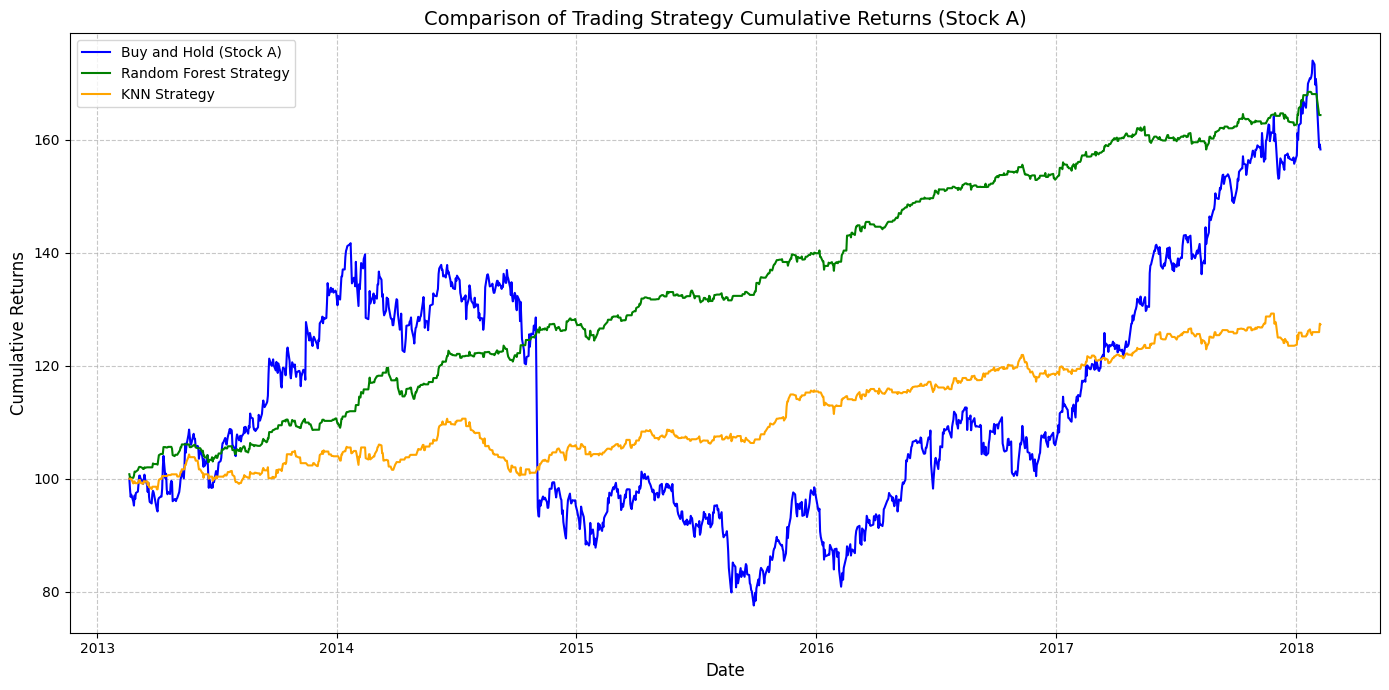

In [ ]:
# Isolate features
feature_columns = ['PrevDayClose', 'PrevDayOpen', 'PrevDayVolume', 'PrevDayHigh', 'PrevDayLow',
                   'LogRet_1', 'LogRet_2', 'LogRet_3', 'LogRet_4', 'LogRet_5']
X_predict = df_predict[feature_columns]

# Scale the features
X_predict_rf_scaled = global_rf_scaler.transform(X_predict)
X_predict_knn_scaled = global_knn_scaler.transform(X_predict)

# Predict with random forest
df_predict['RF_Prediction'] = global_forest_model.predict(X_predict_rf_scaled)

# Predict with KNN
df_predict['KNN_Prediction'] = global_knn_model.predict(X_predict_knn_scaled)

# Filter for a single stock 'A'  for Buy and Hold demonstration
df_single_stock = df_predict[df_predict['Name'] == 'A'].copy()

# Calculate daily return for 'Buy and Hold'
df_single_stock['Buy_Hold_Daily_Return'] = df_single_stock['Close'].pct_change().fillna(0)

#  Simulate trading strategy for random forest
df_single_stock['RF_Daily_Profit_Loss'] = df_single_stock.apply(
    lambda row: (row['Close'] - row['Open']) if row['RF_Prediction'] == True else 0,
    axis=1
)

#  Simulate trading strategy for KNN model
df_single_stock['KNN_Daily_Profit_Loss'] = df_single_stock.apply(
    lambda row: (row['Close'] - row['Open']) if row['KNN_Prediction'] == True else 0,
    axis=1
)

# Calculate cumulative returns for all three strategies
# Assuming an initial investment of 100
initial_investment = 100

df_single_stock['Buy_Hold_Cumulative_Return'] = initial_investment * (1 + df_single_stock['Buy_Hold_Daily_Return']).cumprod()
df_single_stock['RF_Cumulative_Return'] = initial_investment + df_single_stock['RF_Daily_Profit_Loss'].cumsum()
df_single_stock['KNN_Cumulative_Return'] = initial_investment + df_single_stock['KNN_Daily_Profit_Loss'].cumsum()

# Plot the cumulative returns
plt.figure(figsize=(14, 7))
plt.plot(df_single_stock['Date'], df_single_stock['Buy_Hold_Cumulative_Return'], label='Buy and Hold (Stock A)', color='blue')
plt.plot(df_single_stock['Date'], df_single_stock['RF_Cumulative_Return'], label='Random Forest Strategy', color='green')
plt.plot(df_single_stock['Date'], df_single_stock['KNN_Cumulative_Return'], label='KNN Strategy', color='orange')

# Label plot elements
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Returns', fontsize=12)
plt.title('Comparison of Trading Strategy Cumulative Returns (Stock A)', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

The plot conveys the relative financial performance of actively managing investments using machine learning predictions versus a passive investment strategy. It helps assess the practical utility and profitability of the developed models for predicting stock movements for Stock A.

*   The **blue line ('Buy and Hold (Stock A)')** represents the cumulative return of a passive investment strategy where an initial \$100 is invested in Stock A and held throughout the period, reflecting the actual price fluctuations of the stock.
*   The **green line ('Random Forest Strategy')** illustrates the cumulative returns of an initial \$100 investment when trades are executed based on the Random Forest model's predictions. A "buy" action is simulated, generating profit based on the daily `Close - Open` price difference, only when the model predicts a positive profit for the day.
*   The **orange line ('KNN Strategy')** shows the cumulative returns of an initial \$100 investment based on the K-Nearest Neighbors (KNN) model's predictions, following the same trading logic as the Random Forest strategy.

### Insights and Conclusion


This tutorial provides an overview of the datascience lifecycle as applied to the topic of financial analyis. We walk the user through the entire data science pipeline. Starting with a kaggle dataset we curated and parsed the data before transforming it into actionable insights through exploratory data analysis. We developed hypothesis and tested them using popular machine learning like KNN. Finally we visualized this data for our user.


The user learned how to import and clean financial data, draw conclusions about market volatility, stock market correlation, stock growth, and company profit margins. It teaches a generalized framework to test stock market predictions with hard data. The tutorial is purposeful broad and leaves many financial topics uncovered, for the user to later explore. It teaches basic datascience principles that allow users to explore more advanced topics on their own. Here are a list of more advanced questions that we encourage users to answer using their new found data science knowledge!


*  How can historical political and social contexts be woven into the financial picture to further explain stock market relations
*  How can we evaluate momentum of stocks? Do certain stocks have higher potential gain in shorter periods of time?
*  What is the relation between stock growth and more common ticker indicators like earnings per share, price to earnings ratio, and dividend yield?
*  How can moving averages help to explain stock market trends?



Taking real world questions and evaluating them using hard data is a skill applicable to all facets of your life. It lets you move from shaky hypothesis to hard proof through the power of science! We hope the skills you learned here will stick with you beyond financial data analysis and will be of use in all areas you study.
